<a href="https://colab.research.google.com/github/PedroDubas/Forest_Classification/blob/master/Florest_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir /root/.kaggle
meu_json = '{"username":"kleyer","key":"b986abecaefe13f01f8073272b3c6f7e"}'
with open('/root/.kaggle/kaggle.json', 'w+') as f:
    f.write(meu_json)

In [0]:
!kaggle competitions download -c forest-cover-type-prediction

  0% 0.00/1.19M [00:00<?, ?B/s]
100% 1.19M/1.19M [00:00<00:00, 40.3MB/s]
 78% 9.00M/11.5M [00:00<00:00, 32.4MB/s]
100% 11.5M/11.5M [00:00<00:00, 38.3MB/s]
  0% 0.00/333k [00:00<?, ?B/s]
100% 333k/333k [00:00<00:00, 101MB/s]


In [0]:
!unzip "train.csv.zip"
!unzip "test.csv.zip"

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [0]:
import sys 
print("Python version: {}". format(sys.version))

import pandas as pd 
print("pandas version: {}". format(pd.__version__))

import matplotlib.pyplot as plt
import matplotlib
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np 
print("NumPy version: {}". format(np.__version__))

import scipy as sp 
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display 
print("IPython version: {}". format(IPython.__version__)) 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,make_scorer,f1_score, auc, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV , KFold,train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble, tree, svm, naive_bayes, neighbors, linear_model, gaussian_process, neural_network
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels
import sklearn 
print("scikit-learn version: {}". format(sklearn.__version__))

import re
print("re version: {}". format(re.__version__))

import seaborn as sns

from collections import Counter

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

#misc libraries
import random
import time

from itertools import cycle


import warnings
warnings.filterwarnings('ignore')

Python version: 3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
pandas version: 0.24.2
matplotlib version: 3.0.3
NumPy version: 1.16.4
SciPy version: 1.3.0
IPython version: 5.5.0
scikit-learn version: 0.21.2
re version: 2.2.1


In [0]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

fulldata = test
fulldata= fulldata.append(train)

print("Teste: {}\nTreino: {}\nFull_data:{}".format(test.shape,train.shape,fulldata.shape))

Teste: (565892, 55)
Treino: (15120, 56)
Full_data:(581012, 56)


In [0]:
fulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 581012 entries, 0 to 15119
Data columns (total 56 columns):
Aspect                                581012 non-null int64
Cover_Type                            15120 non-null float64
Elevation                             581012 non-null int64
Hillshade_3pm                         581012 non-null int64
Hillshade_9am                         581012 non-null int64
Hillshade_Noon                        581012 non-null int64
Horizontal_Distance_To_Fire_Points    581012 non-null int64
Horizontal_Distance_To_Hydrology      581012 non-null int64
Horizontal_Distance_To_Roadways       581012 non-null int64
Id                                    581012 non-null int64
Slope                                 581012 non-null int64
Soil_Type1                            581012 non-null int64
Soil_Type10                           581012 non-null int64
Soil_Type11                           581012 non-null int64
Soil_Type12                           581012 non-

In [0]:
train.drop(['Id'],axis=1,inplace=True)
X = train.drop(['Cover_Type'],axis =1)
Y = train['Cover_Type']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=42)

In [0]:
print("important features to Cover_Type")
corr = train.corr()
corr.sort_values(["Cover_Type"], ascending=False, inplace=True)
print(corr.Cover_Type[:15])
MostImportant = corr.Cover_Type[:40].index
#MostImportant = MostImportant.drop(['Cover_Type'])

important features to Cover_Type
Cover_Type                        1.000000
Soil_Type38                       0.257810
Soil_Type39                       0.240384
Soil_Type40                       0.205851
Soil_Type10                       0.128972
Wilderness_Area3                  0.122146
Soil_Type35                       0.114327
Slope                             0.087722
Wilderness_Area4                  0.075774
Vertical_Distance_To_Hydrology    0.075647
Soil_Type37                       0.071210
Soil_Type17                       0.042453
Soil_Type13                       0.040528
Soil_Type5                        0.027692
Soil_Type36                       0.025726
Name: Cover_Type, dtype: float64


In [0]:
MLA = [
    ensemble.AdaBoostClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    #gaussian_process.GaussianProcessClassifier(),
    linear_model.LogisticRegressionCV(),
    linear_model.RidgeClassifierCV(),
    linear_model.Perceptron(),
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    neighbors.KNeighborsClassifier(),
    #svm.SVC(probability=True),
    #svm.NuSVC(probability=True),
    svm.LinearSVC(),
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    xgb.XGBClassifier()
    ]

In [0]:
import time

col = []
algorithms = pd.DataFrame(columns = col)
idx = 0

#Train and score algorithms
for a in MLA:
    
    print(a.__class__.__name__)
    inicio = time.time()
    print("Fitting..   " )
    a.fit(X_train, Y_train)
    print("Predicting..")
    pred = a.predict(X_test)
    print("Medindo..")
    acc = accuracy_score(Y_test, pred) #Other way: a.score(X_test, y_test)
    f1 = f1_score(Y_test, pred , average ='micro')
    cv = cross_val_score(a, X_train, Y_train).mean()
    print("Acc:{} \nF1: {}\nCv: {}".format(round(acc * 100, 2),round(f1 * 100, 2),round(cv * 100, 2)))
    fim = time.time()
    print("Total: ",fim - inicio)
    print("-"*25)
    
    Alg = a.__class__.__name__
    
    algorithms.loc[idx, 'Algorithm'] = Alg
    algorithms.loc[idx, 'Accuracy'] = round(acc * 100, 2)
    algorithms.loc[idx, 'F1 Score'] = round(f1 * 100, 2)
    algorithms.loc[idx, 'CV Score'] = round(cv * 100, 2)

    idx+=1

AdaBoostClassifier
Fitting..   
Predicting..
Medindo..
Acc:0.2945326278659612 
F1: 0.2945326278659612
Cv: 0.4148292950430552
Total:  3.7008843421936035
-------------------------
ExtraTreesClassifier
Fitting..   
Predicting..
Medindo..
Acc:0.8406084656084656 
F1: 0.8406084656084656
Cv: 0.8143418300292714
Total:  0.6317341327667236
-------------------------
GradientBoostingClassifier
Fitting..   
Predicting..
Medindo..
Acc:0.8088624338624338 
F1: 0.808862433862434
Cv: 0.7995056218084086
Total:  45.478116512298584
-------------------------
RandomForestClassifier
Fitting..   
Predicting..
Medindo..
Acc:0.8276014109347443 
F1: 0.8276014109347443
Cv: 0.8154758598848592
Total:  0.73557448387146
-------------------------
LogisticRegressionCV
Fitting..   
Predicting..
Medindo..
Acc:0.5978835978835979 
F1: 0.5978835978835979
Cv: 0.6002445763721792
Total:  124.93671798706055
-------------------------
RidgeClassifierCV
Fitting..   
Predicting..
Medindo..
Acc:0.6371252204585538 
F1: 0.6371252204585

In [0]:
algorithms.sort_values(by = ['CV Score'], ascending = False, inplace = True)    
algorithms.head()

,Algorithm,Accuracy,F1 Score,CV Score
3,RandomForestClassifier,82.76,82.76,81.55
1,ExtraTreesClassifier,84.06,84.06,81.43
2,GradientBoostingClassifier,80.89,80.89,79.95
9,KNeighborsClassifier,80.49,80.49,77.23
11,DecisionTreeClassifier,77.73,77.73,75.95


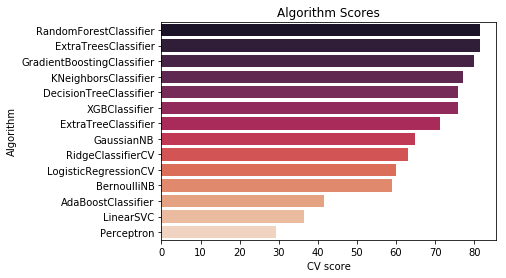

In [0]:
g = sns.barplot("CV Score", "Algorithm", data = algorithms,palette="rocket")
g.set_xlabel("CV score")
g = g.set_title("Algorithm Scores")

In [0]:
kfold = StratifiedKFold(n_splits=10)

In [0]:
rf = RandomForestClassifier()
parameters = {'n_estimators': [300], 
              'min_samples_split': [2],
              'min_samples_leaf': [1],
              'random_state':[42],
              'max_features':[.3]
              }

acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(rf, parameters, scoring=acc_scorer,verbose=1,n_jobs=4,cv=kfold)
grid_obj = grid_obj.fit(X_train, Y_train)
#grid_obj = grid_obj.fit(X, Y) #Full data Train

RF_best = grid_obj.best_estimator_

# Best score
grid_obj.best_score_
#0.8664965986394558

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.1min finished


0.8534580498866213

In [0]:
RF_best.score(X_test,Y_test)

0.86331569664903

In [0]:
RF_pred = RF_best.predict(X_test)

In [0]:
RF_prob = RF_best.predict_proba(X_test)

In [0]:
from sklearn.preprocessing import label_binarize
Target_binary = label_binarize(Y_test, classes=[1, 2, 3, 4, 5, 6, 7])

In [0]:
def Plot_ROC(Target,Proba,classes):
    Target_binary = label_binarize(Target, classes=classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = Proba.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Target_binary[:, i], Proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','blue','black','green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.02])
    plt.ylim([-0.01, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax

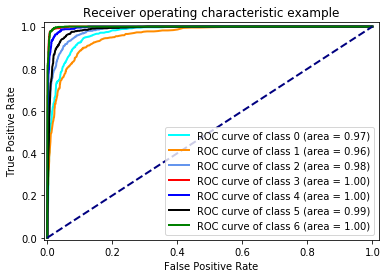

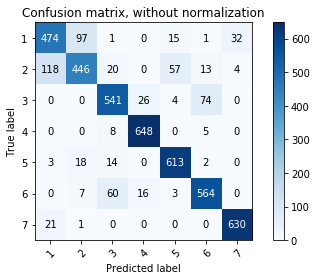

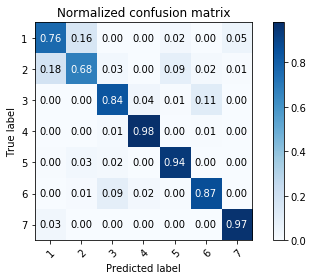

In [0]:
np.set_printoptions(precision=2)

Plot_ROC(Y_test,RF_prob,[1,2,3,4,5,6,7])

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, RF_pred, classes=class_names,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, RF_pred, classes=class_names, normalize=True,title='Normalized confusion matrix')

plt.show()

In [0]:
ExTrC = ensemble.ExtraTreesClassifier()
ExTrC.get_params
parm={
    'n_estimators':[100,130,150,190],
    'criterion':['gini']
}

acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(ExTrC, parm, scoring=acc_scorer,verbose=1,n_jobs=4,cv=kfold)
grid_obj = grid_obj.fit(X_train, Y_train)
#grid_obj = grid_obj.fit(X, Y) #Full data Train

ExTrC_best = grid_obj.best_estimator_

# Best score
grid_obj.best_score_
#0.8533635676492819

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:  1.4min finished


0.854119425547997

In [0]:
ExTrC_best.score(X_test,Y_test)

0.8624338624338624

In [0]:
ExTrC_proba = ExTrC_best.predict_proba(X_test)
ExTrC_pred = ExTrC_best.predict(X_test)

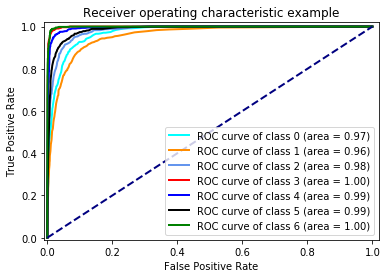

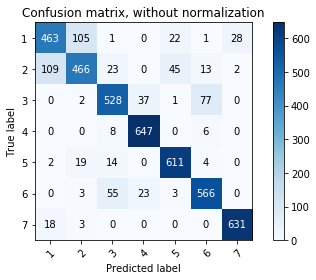

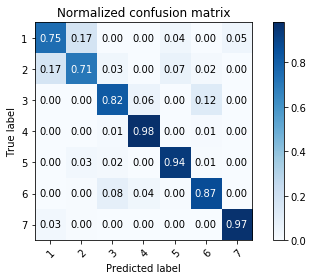

In [0]:
np.set_printoptions(precision=2)

Plot_ROC(Y_test,ExTrC_proba,[1,2,3,4,5,6,7])

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, ExTrC_pred, classes=class_names,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, ExTrC_pred, classes=class_names, normalize=True,title='Normalized confusion matrix')

plt.show()

In [0]:
pred = ExTrC_best.predict(test.drop(['Id'],axis=1))

results = pd.DataFrame({"Id": test["Id"].astype('Int32'), "Cover_Type": pred})
results.to_csv("Florest_V3.csv", index=False)